In [ ]:
#https://www.kaggle.com/code/tahmidhasansakib/visual-product-recommendation-system-using-cnn

In [3]:
#!pip install tensorflow

In [4]:
#pip install opencv-python

In [28]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image
import cv2
import pickle
import warnings
warnings.filterwarnings("ignore")


from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import DenseNet121

In [6]:
df = pd.read_csv("./styles.csv", nrows=6000, error_bad_lines=False)
df['image'] = df.apply(lambda x: str(x['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
print(df.shape)
df.head(5)

(6000, 11)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


In [7]:
Dataframe = pd.DataFrame({
    'image_name': df['image'],
    'type': df['articleType']
})

# total number of entries in the dataframe
total_row = len(Dataframe)
print('total row count: ', total_row)

Dataframe.head(10)

total row count:  6000


,image_name,type
0,15970.jpg,Shirts
1,39386.jpg,Jeans
2,59263.jpg,Watches
3,21379.jpg,Track Pants
4,53759.jpg,Tshirts
5,1855.jpg,Tshirts
6,30805.jpg,Shirts
7,26960.jpg,Shirts
8,29114.jpg,Socks
9,30039.jpg,Watches


In [8]:
unique_types = Dataframe['type'].unique().tolist()
total_class = len(unique_types)
print(total_class)
print(unique_types)
print(unique_types[0])
print(unique_types.index(unique_types[0]))
Dataframe['number_types'] = Dataframe['type'].apply(lambda x: unique_types.index(x) if x in unique_types else 0)
Dataframe.head(10)

117
['Shirts', 'Jeans', 'Watches', 'Track Pants', 'Tshirts', 'Socks', 'Casual Shoes', 'Belts', 'Flip Flops', 'Handbags', 'Tops', 'Bra', 'Sandals', 'Shoe Accessories', 'Sweatshirts', 'Deodorant', 'Formal Shoes', 'Bracelet', 'Lipstick', 'Flats', 'Kurtas', 'Waistcoat', 'Sports Shoes', 'Shorts', 'Briefs', 'Sarees', 'Perfume and Body Mist', 'Heels', 'Sunglasses', 'Innerwear Vests', 'Pendant', 'Nail Polish', 'Laptop Bag', 'Scarves', 'Rain Jacket', 'Dresses', 'Night suits', 'Skirts', 'Wallets', 'Blazers', 'Ring', 'Kurta Sets', 'Clutches', 'Shrug', 'Backpacks', 'Caps', 'Trousers', 'Earrings', 'Camisoles', 'Boxers', 'Jewellery Set', 'Dupatta', 'Capris', 'Lip Gloss', 'Bath Robe', 'Mufflers', 'Tunics', 'Jackets', 'Trunk', 'Lounge Pants', 'Face Wash and Cleanser', 'Necklace and Chains', 'Duffel Bag', 'Sports Sandals', 'Foundation and Primer', 'Sweaters', 'Free Gifts', 'Trolley Bag', 'Tracksuits', 'Swimwear', 'Shoe Laces', 'Fragrance Gift Set', 'Bangle', 'Nightdress', 'Ties', 'Baby Dolls', 'Legging

,image_name,type,number_types
0,15970.jpg,Shirts,0
1,39386.jpg,Jeans,1
2,59263.jpg,Watches,2
3,21379.jpg,Track Pants,3
4,53759.jpg,Tshirts,4
5,1855.jpg,Tshirts,4
6,30805.jpg,Shirts,0
7,26960.jpg,Shirts,0
8,29114.jpg,Socks,5
9,30039.jpg,Watches,2


In [9]:
Dataframe['type'].value_counts()

Tshirts             900
Shirts              417
Casual Shoes        375
Watches             366
Sports Shoes        311
                   ... 
Trolley Bag           1
Beauty Accessory      1
Water Bottle          1
Shrug                 1
Jeggings              1
Name: type, Length: 117, dtype: int64

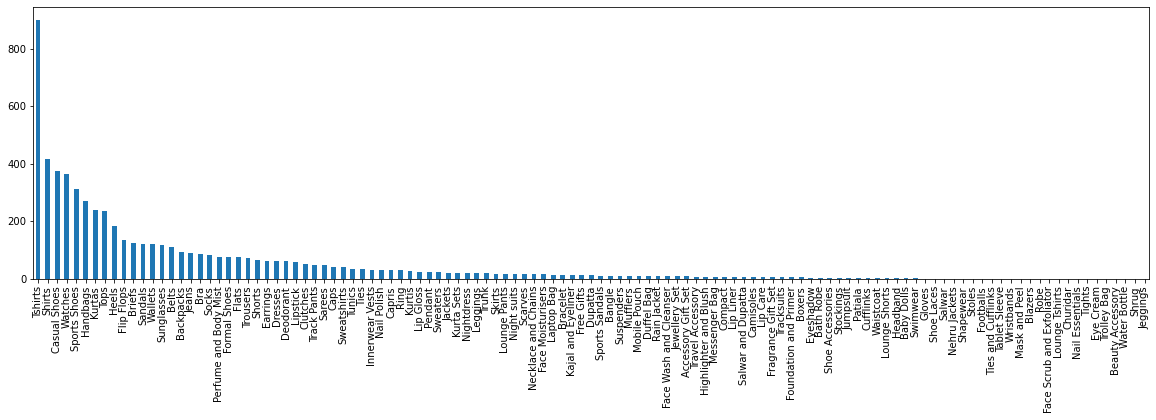

In [10]:
plt.figure(figsize=(20,5))
Dataframe['type'].value_counts().plot(kind='bar',x='type',y='image_name')
plt.show()

In [38]:
#Starting with train and test data,Inserting Image and Labels in numpy array,Utility Function to get images and inserted into image array
#Start and Stop parameters will be useful train and test separation,Here all X=image_data, Y=label_data¶
import os
DATASET_PATH = "./fashion-dataset/"
list_directory = os.listdir(DATASET_PATH)
# each time directory files gets reordered. That's why needed to find where images folder is.
index=0
for i in range (len(list_directory)):
    if list_directory[i]=="images":
        index=i
        break
def getData(start,stop):
    x_data = []
    y_data = []
    #start = 0 #setting start parameter
    #stop = int(0.001*total_row) #setting stop parameter 
    
    for i in range(start, stop): 
        Image_path=DATASET_PATH+list_directory[index]+"/"+Dataframe.loc[i,'image_name']
        #print(Dataframe.loc[i,'image_name'])
        image = cv2.imread(Image_path,cv2.IMREAD_GRAYSCALE)
        print(image)
        try:
            resized_img = cv2.resize(image, dsize=(28, 28))
        except:
            print("Rejected Image: "+Dataframe.loc[i,'image_name'])
            continue
        x_data.append(resized_img) 
        y_values = Dataframe.loc[i,'number_types'] # earlier it was type
        y_data.append(y_values)
                
    return x_data, y_data

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[255 255 255 ... 255 255 255]
 [255 255

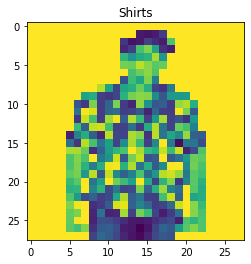

In [39]:
#Test of the function
X=[]
Y=[]
# for now start=0,stop=(0.001*total_row)
# total_row=count of rows in augmented data frame
start = 0
stop = int(0.001*total_row) # testing with 0.1% image of the dataset
X,Y=getData(start,stop)

print(type(X))
print(X[0])
plt.title(unique_types[Y[0]])
plt.imshow(X[0])

In [ ]:
#Successful insertion of images in the array. Also we got the labels required.

In [40]:
#Change into numpy array
X = np.array(X).reshape(-1, 28,28,1)
Y = np.array(Y)
len(Y)

6

In [41]:
#Normalizing by 255
X = X/255.0
len(X)

6

In [42]:
#Processing labels for dimension matching
Y = Y.reshape(len(X),)

In [43]:
#Sample printing
print(type(X))
print(X.shape)
print(Y.shape)
print(X[0])
print(Y[0])

<class 'numpy.ndarray'>
(6, 28, 28, 1)
(6,)
[[[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [0.10196078]
  [0.08627451]
  [0.10588235]
  [0.20784314]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.  

In [44]:
#Adding all the images to numpy array,X=Image Array,Y=Image Label Array
X=[]
Y=[]
start = 0
stop = total_row
X,Y=getData(start,stop)

# conversion into numpy array
X = np.array(X).reshape(-1, 28,28,1)
Y = np.array(Y)

# normalizing
X = X/255

# processing Y_train for dimension matching
Y = Y.reshape(len(X),)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[255 255 255 ... 255 255 255]
 [255 255

In [14]:
print('Image Data Shape: ',X.shape)
print('Label Data Shape: ',Y.shape)

Image Data Shape:  (6000, 28, 28, 1)
Label Data Shape:  (6000,)


In [15]:
#Now we got Image and Label added in the arrays. Next will be Spliting both train and test data.
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 500)
print('Train Image Data Shape: ',X_train.shape)
print('Train Label Data Shape: ',Y_train.shape)
print('Test Image Data Shape: ',X_test.shape)
print('Test Label Data Shape: ',Y_test.shape)

Train Image Data Shape:  (5400, 28, 28, 1)
Train Label Data Shape:  (5400,)
Test Image Data Shape:  (600, 28, 28, 1)
Test Label Data Shape:  (600,)


In [16]:
X_train, X_validate, Y_train, Y_validate = train_test_split(X_train, Y_train, test_size = 0.1, random_state = 500)
print('Train Image Data Shape: ',X_train.shape)
print('Train Label Data Shape: ',Y_train.shape)
print('Validation Image Data Shape: ',X_validate.shape)
print('Validation Label Data Shape: ',Y_validate.shape)

Train Image Data Shape:  (4860, 28, 28, 1)
Train Label Data Shape:  (4860,)
Validation Image Data Shape:  (540, 28, 28, 1)
Validation Label Data Shape:  (540,)


In [17]:
#CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os
import tensorflow as tf
import datetime, os
from tensorflow.keras.callbacks import TensorBoard

In [48]:
#Creating sequential model with three layers
def build_model():
    cnn_model = Sequential()
    cnn_model.add(Conv2D(32, (3, 3), input_shape = (28,28,1), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
    cnn_model.add(Dropout(0.25))

    cnn_model.add(Conv2D(64, (3, 3), input_shape = (28,28,1), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
    cnn_model.add(Dropout(0.25))

    cnn_model.add(Conv2D(128, (3, 3), input_shape = (28,28,1), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
    cnn_model.add(Dropout(0.25))

    cnn_model.add(Flatten())
    cnn_model.add(Dense(units = 512, activation = 'relu'))
    cnn_model.add(Dropout(0.25))
    cnn_model.add(Dense(units = total_class, activation = 'softmax'))
    return cnn_model


model=build_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 5, 5, 64)         

In [59]:
def train_model(model):
    model.compile(loss ='sparse_categorical_crossentropy', optimizer='adam' ,metrics =['accuracy'])
    history = model.fit(X_train, Y_train, batch_size = 128, epochs = 100, verbose = 1, validation_data = (X_validate, Y_validate))
#     model.fit(X_train, Y_train, epochs=50, batch_size=512, validation_split=0.2)

train_model(model)

Epoch 1/100
38/38 [==============================] - 3s 62ms/step - loss: 3.8776 - accuracy: 0.1245 - val_loss: 3.8487 - val_accuracy: 0.1500
Epoch 2/100
38/38 [==============================] - 2s 62ms/step - loss: 3.6120 - accuracy: 0.1496 - val_loss: 3.6937 - val_accuracy: 0.1593
Epoch 3/100
38/38 [==============================] - 2s 62ms/step - loss: 3.3286 - accuracy: 0.1899 - val_loss: 3.1645 - val_accuracy: 0.2296
Epoch 4/100
38/38 [==============================] - 2s 60ms/step - loss: 2.8834 - accuracy: 0.2512 - val_loss: 2.8396 - val_accuracy: 0.2944
Epoch 5/100
38/38 [==============================] - 2s 60ms/step - loss: 2.6320 - accuracy: 0.2916 - val_loss: 2.5926 - val_accuracy: 0.3389
Epoch 6/100
38/38 [==============================] - 2s 65ms/step - loss: 2.4009 - accuracy: 0.3434 - val_loss: 2.3448 - val_accuracy: 0.3907
Epoch 7/100
38/38 [==============================] - 3s 69ms/step - loss: 2.2257 - accuracy: 0.3784 - val_loss: 2.1510 - val_accuracy: 0.4130
Epoch 

Text(0.5, 1.0, 'Accuracy evolution')

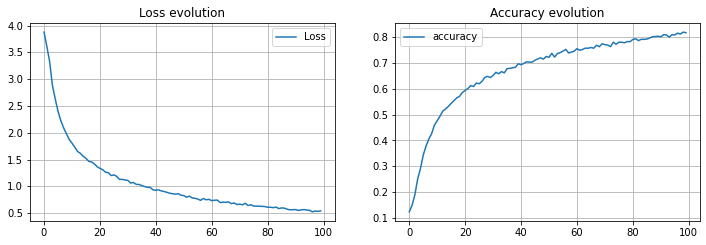

In [60]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(model.history.history['loss'], label='Loss')
# plt.plot(model.history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(model.history.history['accuracy'], label='accuracy')
# plt.plot(model.history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')


In [45]:
from keras import models
model = models.load_model('visual_product_recommend.h5')

In [46]:
model.save('visual_product_recommend.h5')

In [63]:
#predicted_classes = model.predict_classes(X_test)
predict_x=model.predict(X_test) 
predicted_classes=np.argmax(predict_x,axis=1)

19/19 [==============================] - 0s 5ms/step


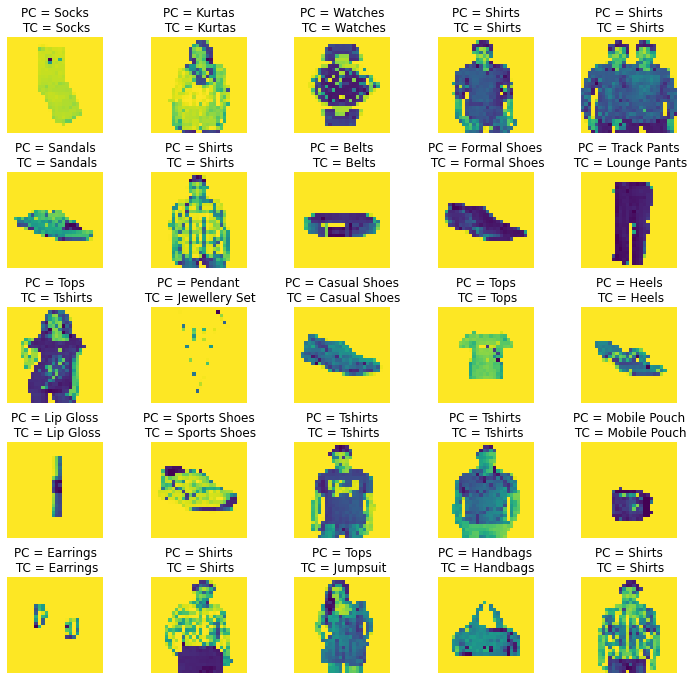

In [77]:
#PC=PredictedClass #TC=TrueClass
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i].reshape(28,28))
    axes[i].set_title(f"PC = {unique_types[predicted_classes[i]]}\n TC = {unique_types[Y_test[i]]}") #predicted_classes[i]:0.1f #Y_test[i]:0.1f
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

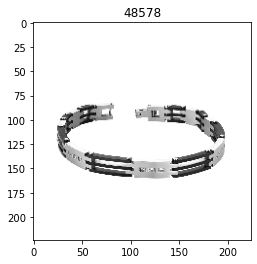

In [102]:
#Dataframe.head(10)
def load_image(i):
    Image_path=DATASET_PATH+list_directory[index]+"/"+Dataframe.loc[i,'image_name']
    Image_id=Dataframe.loc[i,'image_name'].split(".")
    res=Image_id[0]
    image = cv2.imread(Image_path,cv2.IMREAD_COLOR)
    resized_img = cv2.resize(image, dsize=(224, 224))
    return resized_img,res
img,img_id = load_image(150)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.title(img_id)
plt.imshow(img)

In [103]:
def make_prediction(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    resized_img = cv2.resize(img, dsize=(28, 28))
    x_data = np.array(resized_img).reshape(-1, 28,28,1)
    x_data=x_data/255
#     print(x_data)
#     print(x_data.shape)
    result=model.predict(x_data)
#     print(type(result))
#     print(np.argmax(result))
    return x_data,unique_types[np.argmax(result)]

numpy_image,result=make_prediction(img)
print(result)

1/1 [==============================] - 0s 36ms/step
Bracelet


In [104]:
typeList=[]
for i, row in df.iterrows(): 
    if(row["articleType"]==result):
        #print(row["id"],row["articleType"])
        if(img_id!=str(row["id"])):
            typeList.append(row['id'])
            
            
print(typeList) 

[48311, 35128, 48582, 48320, 48576, 48585, 48318, 48584, 48570, 48319, 48577, 48583, 48579]


Text(0.5, 1.0, '48311')

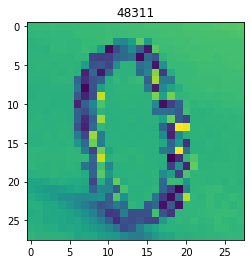

In [105]:
i=0
X_similar=[]
X_id_similar=[]
X_numpy=[]
for imageId in typeList:
#     print(imageId)
    Image_path=DATASET_PATH+list_directory[index]+"/"+str(imageId)+".jpg"
    image = cv2.imread(Image_path,cv2.IMREAD_GRAYSCALE)
    try:
        resized_img = cv2.resize(image, dsize=(28,28))
    except:
        print("can't read file: ", str(imageId)+".jpg")
    X_similar.append(resized_img)
    X_id_similar.append(imageId)
        
X_numpy = np.array(X_similar).reshape(-1, 28,28,1)
X_numpy = X_numpy/255
#print(X_numpy[0])

plt.imshow(X_similar[0])
plt.title(X_id_similar[0])

In [106]:
#Recommendation
import math
def calculateDistance(i1, i2):
    return math.sqrt(np.sum((i1-i2)**2))

print(calculateDistance(numpy_image,X_numpy[0]))

12.060427121178247


In [107]:
distance_list=[]
for i in range (0, len(X_numpy)):
    distance_list.append(calculateDistance(numpy_image,X_numpy[i]))

sorted_distance_list=distance_list.copy()
#print(distance_list)
sorted_distance_list.sort()

least_ten_distance=sorted_distance_list[0:10]
print(least_ten_distance)
index_distance=[]
for i in range (0, len(least_ten_distance)-1):
    if(least_ten_distance[i]!=least_ten_distance[i+1]):
        index_distance.append(distance_list.index(least_ten_distance[i]))

index_distance=index_distance[0:5]

print(index_distance)

[4.049465388744609, 4.3782307234303435, 4.524693238692275, 4.6228790974411025, 4.687436069024499, 4.688398894973127, 4.79614737096333, 5.152648691970774, 5.282210283821227, 5.703371187865506]
[10, 2, 6, 11, 5]


48311
35128
48582
48320
48576


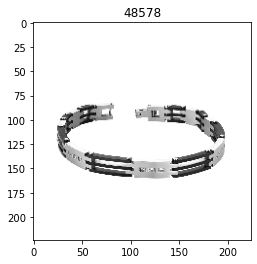

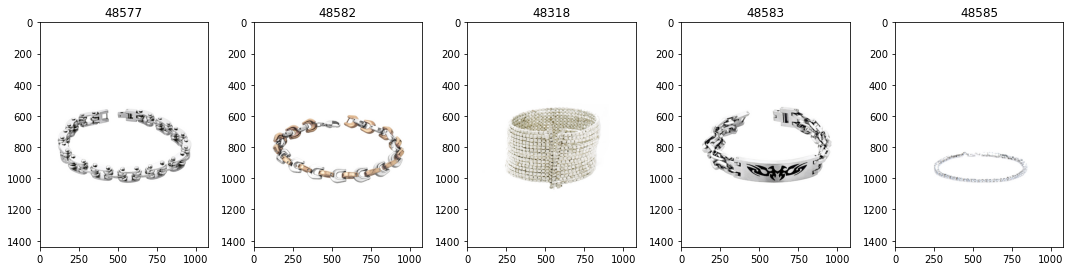

In [108]:
# Image_path=DATASET_PATH+list_directory[index]+"/"+str(img_id)+".jpg"
# src = cv2.imread(Image_path)
# image = cv2.cvtColor(src, cv2.COLOR_BGR2RGB) 
plt.imshow(img)
plt.title(img_id)

fig=plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
axis=[]
for i in range(0,len(index_distance)):
    print(X_id_similar[i])
    Image_path=DATASET_PATH+list_directory[index]+"/"+str(X_id_similar[index_distance[i]])+".jpg"
    src = cv2.imread(Image_path)
    image = cv2.cvtColor(src, cv2.COLOR_BGR2RGB) 
    axis.append(fig.add_subplot(1,5, i+1))
    subplot_title=str(X_id_similar[index_distance[i]])
    axis[-1].set_title(subplot_title)  
    plt.imshow(image)
    
fig.tight_layout()
plt.show()